# EXPLORING ARTIST GENDER BIAS IN MUSIC PREFERENCE AND COLLABORATIVE FILTERING-BASED RECOMMENDATION

Author: Dougal Shakespeare, Lorenzo Porcaro, Emilia Gómez, Carlos Castillo

## Experiment 2. Users with extreme listening preferences for female artists - LFM1b

If not allready done, unpack ```lfm1b-data.zip/``` into this current working directory to have access to all file paths used for this experiment and all subsequent lfm-1b notebooks. 

In [1]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import KFold
import random
import os.path
import requests
import re
import os
import h5py
from scipy import sparse
import csv
import random

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

In [2]:
lfm1b_le75_filtered_mf_path = 'baseline-data/LFM-1b-Le75_mf.csv'
lfm1b_le75_artists_path = 'baseline-data/artists-lfm1b75.csv'
lfm1b_le75_users_path = 'baseline-data/users-lfm1b75.csv'

In [3]:
df_events = pd.read_csv(lfm1b_le75_filtered_mf_path)
artist_mat_le75_df = pd.read_csv(lfm1b_le75_artists_path)
user_mat_le75_df = pd.read_csv(lfm1b_le75_users_path)

In [4]:
# User gender distribution analysis
def compute_user_gender_dist(df_u):
    user_m = df_u[df_u.gender == 'm']
    user_f = df_u[df_u.gender == 'f']
    user_u = df_u[df_u.gender == 'n']
    return user_m, user_f, user_u

def compute_artist_gender_dist(df_a):
    artist_u = df_a[df_a.identified_gender == 0]
    artist_m = df_a[df_a.identified_gender == 1]
    artist_f = df_a[df_a.identified_gender == 2]
    artist_o = df_a[df_a.identified_gender == 3]
    artist_na = df_a[df_a.identified_gender == 4] 
    return artist_u, artist_m, artist_f, artist_o, artist_na

In [5]:
# Gender distribution analysis - artists
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df)

### Preference ratio
We now compute preference ratios and bias disparity as based on the following methodolgy defined in: https://deepai.org/publication/crank-up-the-volume-preference-bias-amplification-in-collaborative-recommendation

$$P R_{S}(G, C)=\frac{\sum_{u \in G} \sum_{i \in C} S(u, i)}{\sum_{u \in G} \sum_{i \in I} S(u, i)}$$


In [6]:
def create_dynamic_dict_list(l):
    return [{} for _ in range(l)]

In [7]:
# preference ratio computation - G = user group, C = item category
def compute_pref_ratio(G, C, s_df):
    s_c = 0
    s_i = 0
    #print(G)
    for u in G:
        # filter to get the artists which the user listens to of category C
        filt_artists = s_df[s_df['user'] == u]
        filt_artists_c = filt_artists[filt_artists['artist'].isin(C)]
        s_c += len(filt_artists_c)
        s_i += len(filt_artists)
    return s_c/s_i

### Bias Disparity
$$B D(G, C)=\frac{P R_{R}(G, C)-P R_{S}(G, C)}{P R_{S}(G, C)}$$

In [8]:
def compute_bias_disparity(prR, prS):
    return (prR - prS) / prS

### Recommendation Functions

In [9]:
## Util functions

# Return top 10 item recommendations from algo predictions 
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Returns dict for each user with tuple: (iid, est, true_r)
def get_all_recs(predictions):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings
    return top_n

def get_top_n_random(t, n=10):
    t_df = pd.DataFrame(testset, columns =['user', 'artist', 'playcount'])
    a_list = t_df['artist'].unique()

    top_n = defaultdict(list)
    for uid, iid, true_r in t:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                # generate 10 recommendations for each user
                top_n[uid].append((random.choice(a_list), i))
    return top_n

def get_top_n_mp(testset, item_dis, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dis[:n].items():
                top_n[uid].append((iid, count))
    return top_n

# Store predictions in csv file to be retirved after 
def predictions_to_csv(algorithm, k, dict_data, path): 
    # save as csv with algorithm and k fold num.
    csv_file = path + algorithm + str(k) + '.csv'
    
    if os.path.isfile(csv_file) == False:
        try:     
            with open(csv_file, 'w+', newline="") as csvfile:
                writer = csv.writer(csvfile)                
                for user_id, artist_recs in dict_data:
                    for artist in artist_recs:
                        writer.writerow([user_id, artist])
        except IOError:
            print("I/O error")
    else: print ('csv file allready exists')
        
def test_set_to_csv(algorithm, k, testset, path):
    path = path + algorithm + str(k) + '-testset' + '.csv'
    with open(path,'w+') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['user_id','artist', 'playcount'])
        for row in testset:
            csv_out.writerow(row)

def train_set_to_csv(algorithm, k, trainset, path):
    path = path + algorithm + str(k) + '-trainset' + '.csv'
    with open(path,'w+') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['user_id','artist', 'playcount'])
        for uid, iid, rating in trainset.all_ratings():
            #print('uid:{}, iid:{}, rating:{}'.format(uid, iid, rating))
            csv_out.writerow([uid, iid, rating])

In [10]:
# preference ratio computation - G = user group, C = item category
def compute_pref_ratio_recs(G, C, alg_recs):
    s_c = 0
    s_i = 0

    for u in G:
        # filter to get the artists which the user listens to of category C
        filt_artists = alg_recs[alg_recs.user_id == u]
        filt_artists_c = filt_artists[filt_artists.rec_artist.isin(C)]
        s_c += len(filt_artists_c)
        s_i += len(filt_artists)
    
    if (s_i == 0):
        return 0
    else: return s_c/s_i

### Experiment 3: Users with bias Listening Preferences for Female artists

In [11]:
sample_dir =  './expr2-lfm1b-final/'
num_folds = 3

results_folder = sample_dir
complete_mf_sample_path = sample_dir + 'lfm-1b-mf-sample-biased.csv'
scaled_mf_sample_path = sample_dir + 'lfm-1b-mf-sample-biased-scaled.csv'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### 0. Remove users who listen to < $M$ unique artists
As defined in http://nets.ii.uam.es/~alejandro/2013/lsrs.pdf, we define constraints $N$ and $M$ to make a top-n recommendation.

In [12]:
N = 10 # 10 values in test set to allow for gender distribution variance
n = 5  # rec list of size 5 
M = 20 

In [13]:
df_events_filt = df_events[df_events.groupby('user').artist.transform(len) >= M]

In [14]:
df_events_filt.user.value_counts()

3043017     11697
2887180      7816
2168304      7719
6852120      6859
6428659      6409
            ...  
48182214       20
49972614       20
47267882       20
45390029       20
49618940       20
Name: user, Length: 42324, dtype: int64

In [15]:
# update and remove artists
df_events = df_events_filt

artist_ids = df_events.artist.unique()
user_ids = df_events.user.unique()

artist_mat_le75_df = artist_mat_le75_df[artist_mat_le75_df.id.isin(artist_ids)]
user_mat_le75_df = user_mat_le75_df[user_mat_le75_df.user_id.isin(user_ids)]

# recompute gender dist
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df)

### 1. Sample 

In [16]:
# Compute_pref_ratio as baseline (i.e. user-artist preferences found in the data)
s_df_events = df_events
userm_max_pr_file = 'userm-max-pr.csv'
userf_max_pr_file = 'userf-max-pr.csv'

In [17]:
## (1.1) order by maximum preference ratio - male users

user_m_max_pr = dict.fromkeys(list(user_m.user_id))
u_count = 0
for u_m in list(user_m.user_id):
    if u_count % 10000 == 0:
        print(u_count/len(user_m))
        
    user_le = s_df_events[s_df_events.user == u_m]
    user_le_length = len(user_le)
    user_le_f = user_le[user_le.artist.isin(list(artist_f.id))] #le for male artists
    
    if user_le_length == 0: pr_f = 0
    else: pr_f = len(user_le_f) / user_le_length
        
    user_m_max_pr[u_m] = pr_f
    u_count += 1

print('writing to csv')
with open(sample_dir + userm_max_pr_file, 'w+', newline="") as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in user_m_max_pr.items():
        writer.writerow([key, value])

0.0
0.3227784771311449
0.6455569542622898
0.9683354313934347
writing to csv


In [18]:
## (1.1) order by maximum preference ratio - male users

# Compute_pref_ratio as baseline (i.e. user-artist preferences found in the data)
user_f_max_pr = dict.fromkeys(list(user_f.user_id))
u_count = 0

for u_f in list(user_f.user_id):
    if u_count % 10000 == 0:
        print(u_count/len(user_f))
        
    user_le = s_df_events[s_df_events.user == u_f]
    user_le_length = len(user_le)
    user_le_f = user_le[user_le.artist.isin(list(artist_f.id))] #le for male artists
    
    if user_le_length == 0: pr_f = 0
    else: pr_f = len(user_le_f) / user_le_length
        
    user_f_max_pr[u_f] = pr_f
    u_count += 1

print('writing to csv')
with open(sample_dir + userf_max_pr_file, 'w+', newline="") as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in user_f_max_pr.items():
        writer.writerow([key, value])

0.0
0.8816009873931059
writing to csv


In [19]:
with open(sample_dir + userm_max_pr_file) as csv_file:
    reader = csv.reader(csv_file)
    user_m_max_pr = dict(reader)

with open(sample_dir + userf_max_pr_file) as csv_file:
    reader = csv.reader(csv_file)
    user_f_max_pr = dict(reader)

In [20]:
scaled_df_events = pd.DataFrame()
scaled_df_events = pd.DataFrame()
# all possible male and female users with high listening preference for female artists
m_ids = [int(m_id) for (m_id, pr) in user_m_max_pr.items() if float(pr) >= 0.6]
f_ids = [int(f_id) for (f_id, pr) in user_f_max_pr.items() if float(pr) >= 0.6]

print('Male users with extreme pref for f artists: {}'.format(len(m_ids)))
print('Female users with extreme pref for f artists: {}'.format(len(f_ids)))

Male users with extreme pref for f artists: 100
Female users with extreme pref for f artists: 35


In [21]:
sample_size = 100

user_m_prop = len(user_m) / (len(user_m) + len(user_f))
user_f_prop = len(user_f) / (len(user_m) + len(user_f))
user_m_cutoff = int(sample_size*user_m_prop)
user_f_cutoff = int(sample_size*user_f_prop)

# sample
s_m = random.sample(range(0, len(m_ids)), user_m_cutoff)
s_f = random.sample(range(0, len(f_ids)), user_f_cutoff)

user_sample = []

print('sampling!')
# randomly sample half the users in index range
for i in s_m:
    sampled_user = m_ids[i]
    user_sample.append(sampled_user)
    
for i in s_f:
    sampled_user = f_ids[i]
    user_sample.append(sampled_user)

sampling!


In [22]:
s_df_events = df_events[df_events.user.isin(user_sample)]

### 2. Scale listening counts logarithmically

In [23]:
import math 

#s_df_events = pd.read_csv(complete_mf_sample_path)
scaled_df_events = pd.DataFrame()
u_count = 0
user_len = len(s_df_events.user.unique())

for user_id, group in s_df_events.groupby('user'):
    if u_count % 1000 == 0:
        print(u_count/user_len)

    pc = group['playcount'].values
    pc_scaled = [math.log(p, 1.02) for p in pc]
    new_rows = group.copy()
    new_rows['playcount'] = pc_scaled

    scaled_df_events = scaled_df_events.append(new_rows)
    scaled_df_events = scaled_df_events.append(new_rows)
    u_count +=1
    
scaled_df_events.to_csv(scaled_mf_sample_path, index = False)  

0.0


In [24]:
#read csv 
sample_df_events = pd.read_csv(scaled_mf_sample_path)
sample_df_events['playcount'] = sample_df_events['playcount'].apply(lambda x: x+1)

In [25]:
print('max scaled count:', sample_df_events.playcount.max())
print('min scaled count:', sample_df_events.playcount.min())
print('average scaled count', sample_df_events.playcount.mean())
print('std scaled count', sample_df_events.playcount.std())

max scaled count: 469.4007843082169
min scaled count: 1.0
average scaled count 101.43499651771887
std scaled count 88.553926803793


### Compute Artists in the Longtail

In [26]:
# Compute artists which are in the longtail
artist_unique_users = sample_df_events['artist'].value_counts()
artist_playcounts = sample_df_events[['artist','playcount']].groupby(['artist']).mean()

combined_df = pd.concat([artist_unique_users , artist_playcounts], axis=1)
    
combined_df.columns = ['user_count', 'avg_playcount']
combined_df['popularity'] = combined_df['user_count']*combined_df['avg_playcount']
combined_df = combined_df.sort_values(by=['popularity'])
artists = combined_df.index.values.tolist()
slice_i = int(len(artists) * 0.8) #consider 80% as the longtail
lt_artists = artists[:slice_i]

### Compute Pref ratios

In [27]:
## Compute input preference ratios

#s_df_events = sample_df_events

# initialise to be filled
pref_ratio_results = np.zeros((2,3))
pref_ratio_data = {}

# user/artist preference labels
names = ['m/m', 'm/f',
         'f/m', 'f/f']

user_ids = s_df_events.user.unique()
artist_ids = s_df_events.artist.unique()

m_user_ids = list(set(user_ids) & set(user_m.user_id))
f_user_ids = list(set(user_ids) & set(user_f.user_id))
m_artist_id = list(set(artist_ids) & set(artist_m.id))
f_artist_id = list(set(artist_ids) & set(artist_f.id))

male_user_interactions = s_df_events[s_df_events.user.isin(m_user_ids)]
male_user_artist_ids = male_user_interactions.artist.unique()

female_user_interactions = s_df_events[s_df_events.user.isin(f_user_ids)]
female_user_artist_ids = female_user_interactions.artist.unique()

m_m_interactions = male_user_interactions[male_user_interactions.artist.isin(m_artist_id)]
m_f_interactions = male_user_interactions[male_user_interactions.artist.isin(f_artist_id)]

f_m_interactions = female_user_interactions[female_user_interactions.artist.isin(m_artist_id)]
f_f_interactions = female_user_interactions[female_user_interactions.artist.isin(f_artist_id)]

a_m_pr = (len(m_m_interactions)+len(f_m_interactions))/(len(male_user_interactions)+len(female_user_interactions))
a_f_pr = (len(m_f_interactions)+len(f_f_interactions))/(len(male_user_interactions)+len(female_user_interactions))
pref_ratio_results[0,2] = a_m_pr
pref_ratio_results[1,2] = a_f_pr

pref_ratio_data['a/m'] = a_m_pr
pref_ratio_data['a/f'] = a_f_pr

pref_ratio_results[0,0] = len(m_m_interactions)/len(male_user_interactions)
pref_ratio_data['m/m'] = pref_ratio_results[0,0]

pref_ratio_results[0,1] = len(f_m_interactions)/len(female_user_interactions)
pref_ratio_data['f/m'] = pref_ratio_results[0,1]

pref_ratio_results[1,0] = len(m_f_interactions)/len(male_user_interactions)
pref_ratio_data['m/f'] = pref_ratio_results[1,0]

pref_ratio_results[1,1] = len(f_f_interactions)/len(female_user_interactions)
pref_ratio_data['f/f'] = pref_ratio_results[1,1]

print('--STATS FOR USER - ITEM INTERACTIONS IN SAMPLE--\n')
                                     
print('total number of users', len(user_ids))
print('total number of male users:', len(m_user_ids))
print('total number of female users:', len(f_user_ids))
print('total number of artists', len(artist_ids))
print('total number of male artists:', len(m_artist_id))
print('total number of female artists:', len(f_artist_id))

print('\n--Sparsity of user-item interactions--')

print('\nmale user - arist interactions', len(male_user_interactions))
print('sparsity of male user interactions: {} / {}'.format(len(male_user_artist_ids), len(male_user_artist_ids)/len(artist_ids)))
print('sparsity of female user interactions: {} / {}'.format(len(female_user_artist_ids), len(female_user_artist_ids)/len(artist_ids)))

print('\n--Input preference ratios for user-item interactions--')

print('\nmale user - male arist interactions: {} / {}'.format(len(m_m_interactions), pref_ratio_results[0,0]))
print('male user - female arist interactions: {} / {}'.format(len(m_f_interactions), pref_ratio_results[1,0]))

print('\nnumber of female user - artist interactions',len(female_user_interactions))
print('female user - male arist interactions: {} / {}'.format(len(f_m_interactions), pref_ratio_results[0,1]))
print('female user - female arist interactions: {} / {}\n'.format(len(f_f_interactions),pref_ratio_results[1,1]))

print('\n--Final Input pref ratio matrix--\n')
print(pref_ratio_results)

--STATS FOR USER - ITEM INTERACTIONS IN SAMPLE--

total number of users 99
total number of male users: 73
total number of female users: 26
total number of artists 7590
total number of male artists: 3181
total number of female artists: 4409

--Sparsity of user-item interactions--

male user - arist interactions 11783
sparsity of male user interactions: 6135 / 0.808300395256917
sparsity of female user interactions: 3056 / 0.40263504611330697

--Input preference ratios for user-item interactions--

male user - male arist interactions: 3933 / 0.33378596282780276
male user - female arist interactions: 7850 / 0.6662140371721972

number of female user - artist interactions 4023
female user - male arist interactions: 1225 / 0.3044991300024857
female user - female arist interactions: 2798 / 0.6955008699975143


--Final Input pref ratio matrix--

[[0.33378596 0.30449913 0.32633177]
 [0.66621404 0.69550087 0.67366823]]


### 3. Make Recommendations


In [44]:
num_folds = 3
trainset_paths = [sample_dir + 'trainset' + str(i) + '.csv' for i in range(num_folds)]
testset_paths = [sample_dir + 'testset' + str(i) + '.csv' for i in range(num_folds)]#

fold_testsets = [[],[],[]]
fold_trainsets = [sample_df_events, sample_df_events, sample_df_events]

#trainset_path = sample_dir + 'trainset.csv'
#testset_path = sample_dir + 'testset.csv'

In [36]:
item_dist = sample_df_events['artist'].value_counts()

In [48]:
## create testsets

grouped = sample_df_events.groupby('user')

for i in range(num_folds):
    top_n_testset = grouped.apply(lambda x: x.sample(10))
    fold_testsets[i] = top_n_testset

In [49]:
## create trainsets

for i in range(len(fold_trainsets)):
    indexes_sample = [x[1] for x in fold_testsets[i].index]
    fold_trainsets[i] = fold_trainsets[i].drop(indexes_sample)

In [50]:
# write train and test set to csv

for i in range(len(fold_trainsets)):
    fold_trainsets[i].to_csv(trainset_paths[i], index_label = False, index = False)  
    fold_testsets[i].to_csv(testset_paths[i], index_label = False, index = False)  

In [51]:
## read train and test sets to df

for i in range(len(fold_trainsets)):   
    fold_trainsets[i] = pd.read_csv(trainset_paths[i])
    fold_testsets[i] = pd.read_csv(testset_paths[i])

In [25]:
"""
data_samples = [] #collection of data to be used as train set for cross validation
test_sets = [] #final test set to be used for final modal evaluations on each of the samples

# Kfold cross validation function
num_folds = 3 
kf = KFold(n_splits=num_folds)

reader = Reader(rating_scale=(sample_df_events['playcount'].min(), sample_df_events['playcount'].max()))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(sample_df_events, reader)
"""

In [52]:
def dict_to_df(dic):
    list_for_df = []

    for key, value in dic.items():
        for rating in value:
            row = rating + (int(key),)
            list_for_df.append(row)
    df = pd.DataFrame(list_for_df, columns = ['artist_id', 'est_score', 'act_score', 'user_id'])
    return df

In [53]:
from surprise.model_selection import PredefinedKFold

random_rec_dict = create_dynamic_dict_list(num_folds)
mostpop_rec_dict = create_dynamic_dict_list(num_folds)
useritemavg_rec_dict = create_dynamic_dict_list(num_folds)
userknnavg_rec_dict = create_dynamic_dict_list(num_folds)
nmf_rec_dict = create_dynamic_dict_list(num_folds)

sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = []  # Random and MostPopular is calculated by default
algos.append(None)
algos.append(None)
algos.append(BaselineOnly())
algos.append(KNNWithMeans(sim_options=sim_users, k=20))
algos.append(NMF(n_factors=300, n_epochs=120))

algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']

sim_users = {'name': 'cosine', 'user_based': True} 

algo_dicts = [random_rec_dict,
              mostpop_rec_dict,
              useritemavg_rec_dict,
              userknnavg_rec_dict,
              nmf_rec_dict]

reader = Reader(sep = ',', skip_lines = 1,rating_scale=(sample_df_events['playcount'].min(), sample_df_events['playcount'].max()))


for f in range(num_folds): 
    
    print('Fold {}:\n'.format(str(f)))
    
    folds_files = [(trainset_paths[f], testset_paths[f])]
    data = Dataset.load_from_folds(folds_files, reader=reader)
    pkf = PredefinedKFold()

    for trainset, testset in pkf.split(data):

        for i in range(0, len(algo_names)):
            print('--------------------------------------------------')
            print(algo_names[i])

            predictions_path = results_folder
            all_recs_path = predictions_path + algo_names[i] + '-recs.csv'
    
            # if we have not allready written csv
            if os.path.isfile(predictions_path + algo_names[i] + str(f) + '.csv') == False: 

                # get accuracy for personalized approaches
                if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular': 
                    algos[i].fit(trainset)  #train
                    predictions = algos[i].test(testset) #get predictions for test set
                
                # get top-n items from recommendations
                if algo_names[i] == 'Random':
                    print('generating random recs...')
                    top_n = get_top_n_random(testset, n=5)
                elif algo_names[i] == 'MostPopular':
                    top_n = get_top_n_mp(testset, item_dist, n=5)
                else:      
                    top_n = get_top_n(predictions, n=5)  
                    #all_recs_order = get_all_recs(predictions)  
                    #all_recs_df = dict_to_df(all_recs_order)
                    #all_recs_df.to_csv(all_recs_path) 
        
                # convert to dict to write to csv
                for uid, user_ratings in top_n.items():
                    artist_recs = [r[0] for r in user_ratings]
                    dict1 = {uid: artist_recs}
                    algo_dicts[i][0].update(dict1)

                # write our predictions for each fold to a csv for bias computations
                predictions_to_csv(algo_names[i], f, algo_dicts[i][0].items(), predictions_path)
            
            else: print('csv allready exists, next fold')

Fold 0:

--------------------------------------------------
Random
generating random recs...
--------------------------------------------------
MostPopular
--------------------------------------------------
UserItemAvg
Estimating biases using als...
--------------------------------------------------
UserKNNAvg
Computing the cosine similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
NMF
Fold 1:

--------------------------------------------------
Random
generating random recs...
--------------------------------------------------
MostPopular
--------------------------------------------------
UserItemAvg
Estimating biases using als...
--------------------------------------------------
UserKNNAvg
Computing the cosine similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
NMF
Fold 2:

--------------------------------------------------
Random
generating random recs...
---------------------

In [55]:
#num_folds = 1
algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']

sample_algo_results_dfs = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]
#sample_algo_all_results_dfs = [{a:[[] for _ in range(num_folds)] for a in algo_names}][0]

In [56]:
# Lets load the results into dataframe:
predictions_path = results_folder

for algo in algo_names:
    for k in range(num_folds):     
        csv_file_recs = results_folder + algo + str(k) + '.csv'
        csv_file_all_recs = predictions_path + algo + '-recs.csv'
        
        cols = ['user_id', 'rec_artist']   
        sample_algo_results_dfs[algo][k] = pd.read_csv(csv_file_recs, sep=',', names=cols)   
        
        """
        if (algo != 'Random') & (algo != 'MostPopular'):
            sample_algo_all_results_dfs[algo][k] = pd.read_csv(csv_file_all_recs, sep=',')
            print(csv_file_all_recs)
        """
        
        print(csv_file_recs)

./expr2-lfm1b-final/Random0.csv
./expr2-lfm1b-final/Random1.csv
./expr2-lfm1b-final/Random2.csv
./expr2-lfm1b-final/MostPopular0.csv
./expr2-lfm1b-final/MostPopular1.csv
./expr2-lfm1b-final/MostPopular2.csv
./expr2-lfm1b-final/UserItemAvg0.csv
./expr2-lfm1b-final/UserItemAvg1.csv
./expr2-lfm1b-final/UserItemAvg2.csv
./expr2-lfm1b-final/UserKNNAvg0.csv
./expr2-lfm1b-final/UserKNNAvg1.csv
./expr2-lfm1b-final/UserKNNAvg2.csv
./expr2-lfm1b-final/NMF0.csv
./expr2-lfm1b-final/NMF1.csv
./expr2-lfm1b-final/NMF2.csv


In [57]:
all_recpref_dict = dict.fromkeys(algo_names)
count = 0

# user/artist preference labels
names = ['m/m', 'm/f',
         'f/m', 'f/f',
         'a/m', 'a/f']

all_rec_pref_ratio_results = [] #for all 3 samples
all_rec_pref_ratio_std = []
    
for algo_name, rec_alg in sample_algo_results_dfs.items():

        algo_recpref_dict = {}
        pref_matrixs = [] #collection of pref matrix for each fold of cross val.
        fold_count = 0
        
        print('--------------------------------------')
        print('Algorithm:', algo_name)
        
        for k in range(num_folds):
            print('kfold =', k)
            f_result = rec_alg[k] #recs from fold
            
            # initialise matrix to be filled
            pref_ratio_results_rec = np.zeros((2,3))
            
            user_list = [m_user_ids, f_user_ids, m_user_ids + f_user_ids]
            artist_list = [m_artist_id, f_artist_id]
    
            y = 0
            i = 0

            # compute the pref ratio matrix
            for u in user_list:
                x = 0
                for a in artist_list:
                    pref_ratio = compute_pref_ratio_recs(u, a, f_result)
                    pref_ratio_results_rec[x,y] = pref_ratio
                    print(names[i], pref_ratio)
                    i+=1
                    x+=1
                y+=1
                
            pref_matrixs.append(pref_ratio_results_rec)
                       
        #compute average over all matracies
        print('computing global average over k fold matracies')
        pref_ratio_results_global = np.mean(pref_matrixs, axis=0)
        pref_ratio_results_std = np.std(pref_matrixs, axis=0)
        
        #add results to our dict as before
        y = 0
        i = 0
        for u in user_list:
            x = 0
            for a in artist_list:
                algo_recpref_dict[names[i]] = pref_ratio_results_global[x,y] 
                print(names[i], pref_ratio_results_global[x,y])
                i+=1
                x+=1
            y+=1
            
        all_rec_pref_ratio_std.append(pref_ratio_results_std)
        all_rec_pref_ratio_results.append(pref_ratio_results_global)
        all_recpref_dict[algo_name] = algo_recpref_dict

--------------------------------------
Algorithm: Random
kfold = 0
m/m 0.35342465753424657
m/f 0.6465753424657534
f/m 0.38846153846153847
f/f 0.6115384615384616
a/m 0.36262626262626263
a/f 0.6373737373737374
kfold = 1
m/m 0.3082191780821918
m/f 0.6917808219178082
f/m 0.3423076923076923
f/f 0.6576923076923077
a/m 0.31717171717171716
a/f 0.6828282828282828
kfold = 2
m/m 0.36712328767123287
m/f 0.6328767123287671
f/m 0.3923076923076923
f/f 0.6076923076923076
a/m 0.37373737373737376
a/f 0.6262626262626263
computing global average over k fold matracies
m/m 0.34292237442922374
m/f 0.6570776255707762
f/m 0.37435897435897436
f/f 0.6256410256410256
a/m 0.3511784511784512
a/f 0.6488215488215489
--------------------------------------
Algorithm: MostPopular
kfold = 0
m/m 0.0
m/f 1.0
f/m 0.0
f/f 1.0
a/m 0.0
a/f 1.0
kfold = 1
m/m 0.0
m/f 1.0
f/m 0.0
f/f 1.0
a/m 0.0
a/f 1.0
kfold = 2
m/m 0.0
m/f 1.0
f/m 0.0
f/f 1.0
a/m 0.0
a/f 1.0
computing global average over k fold matracies
m/m 0.0
m/f 1.0
f/m 0.0

In [58]:
def test_hypothesis(mean_x1, mean_x2, s1, s2, n1, n2):
    s1 = np.power(s1, 2) / n1
    s2 = np.power(s2, 2) / n2
    return (mean_x1-mean_x2)/np.sqrt(s1+s2)

In [59]:
pref_names = ['m/m', 'f/m', 'm/f', 'f/f']
m_m_prefs = [p_m[0][0] for p_m in all_rec_pref_ratio_results[1:]]
f_m_prefs = [p_m[0][1] for p_m in all_rec_pref_ratio_results[1:]]
m_f_prefs = [p_m[1][0] for p_m in all_rec_pref_ratio_results[1:]]
f_f_prefs = [p_m[1][1] for p_m in all_rec_pref_ratio_results[1:]]
prefs = [m_m_prefs, f_m_prefs, m_f_prefs, f_f_prefs]

m_m_prefs_std = [p_m[0][0] for p_m in all_rec_pref_ratio_std[1:]]
f_m_prefs_std = [p_m[0][1] for p_m in all_rec_pref_ratio_std[1:]]
m_f_prefs_std = [p_m[1][0] for p_m in all_rec_pref_ratio_std[1:]]
f_f_prefs_std = [p_m[1][1] for p_m in all_rec_pref_ratio_std[1:]]
prefs_std = [m_m_prefs_std, f_m_prefs_std, m_f_prefs_std, f_f_prefs_std]

a = 0
for algo in algo_names[1:]:
    print('\n',algo)
    for p_name in np.arange(len(pref_names)):
        print('computing statistical significance of pref ratio:', pref_names[p_name])
        std1 = prefs_std[p_name][a]
        avg1 = prefs[p_name][a]
        for n in np.arange(len(algo_names[1:])):
            if n != a:
                std2 = prefs_std[p_name][n]
                avg2 = prefs[p_name][n]
                print('t', test_hypothesis(avg1, avg2, std1, std2, 3, 3))
    a+=1


 MostPopular
computing statistical significance of pref ratio: m/m
t -43.89138284871068
t -18.778113252226195
t -46.75391503851382
computing statistical significance of pref ratio: f/m
t -6.390149301633413
t -11.850332474105338
t -23.145502494313785
computing statistical significance of pref ratio: m/f
t 43.89138284871083
t 18.778113252226177
t 46.75391503851386
computing statistical significance of pref ratio: f/f
t 6.390149301633413
t 11.850332474105347
t 23.14550249431376

 UserItemAvg
computing statistical significance of pref ratio: m/m
t 43.89138284871068
t -1.111182562904447
t -8.089126174325068
computing statistical significance of pref ratio: f/m
t 6.390149301633413
t -0.2713293789876798
t -1.329388102576792
computing statistical significance of pref ratio: m/f
t -43.89138284871083
t 1.111182562904453
t 8.08912617432509
computing statistical significance of pref ratio: f/f
t -6.390149301633413
t 0.27132937898767984
t 1.3293881025767917

 UserKNNAvg
computing statistical signi

In [60]:
# setup for preference ratio plots...
i = 0
m_algo_prefr = [[], [], [], [], [], []]
f_algo_prefr = [[], [], [], [], [], []]
all_algo_prefr = [m_algo_prefr, f_algo_prefr]

# for each algorithm...
for key in all_recpref_dict:
    if key != 'Random': 
        # user pref ratios for different algorithms
        results = all_recpref_dict[key]
        for key1, value1 in results.items():
            # plot for male artist preference to start
            if key1[-1] == 'm': m_algo_prefr[i].append(value1)
            if key1[-1] == 'f': f_algo_prefr[i].append(value1)      
        i+=1 #next algorithm  

In [61]:
# preference ratios for artist gender in the data - i.e. before CF recommendations
all_prefr_data = [ [pref_ratio_data['m/m'], pref_ratio_data['f/m'], pref_ratio_data['a/m']],
                   [pref_ratio_data['m/f'], pref_ratio_data['f/f'], pref_ratio_data['a/f']]]

/home/sishakes/Dougals-work/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


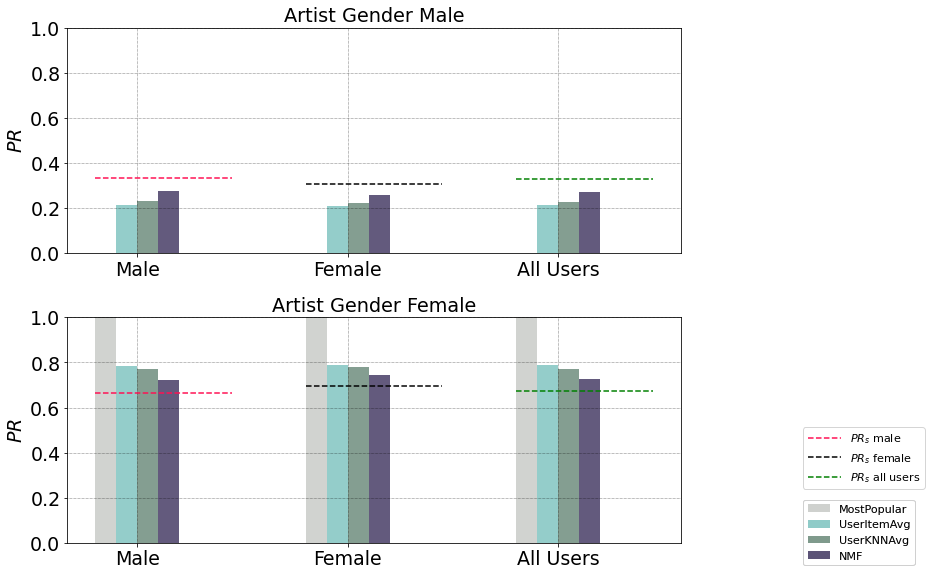

In [62]:
## plot preference changes for male user 
from matplotlib.font_manager import FontProperties

n_groups = 3
algo_names = ['MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']

# create plot
fig = plt.figure(figsize=(10, 20))
plt.rcParams.update({'font.size': 16})

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8
colours = ['#C6C8C5', '#79C1BD', '#668676', '#3C315C', '#BCEBCB', '#BD9391']
colours_inputpr = ['#FF1053', 'black', 'g']
titles = ['Male', 'Female']
lines = []

for j in range(len(all_prefr_data)):
    for i in range(len(algo_names)):
        plt.subplot(5, 1, j+1)
        rects1 = plt.bar(index + bar_width*i, all_algo_prefr[j][i], bar_width,
        alpha=opacity,
        color=colours[i],
        label=algo_names[i])
    for i in index:
        # plot lines to represent pref ratios in data
        lines += plt.plot([-0.05 + i, i+bar_width*6], [all_prefr_data[j][i], all_prefr_data[j][i]], "k--", color=colours_inputpr[i])

    if(j == 1):
        fontP = FontProperties()
        fontP.set_size('x-small')
        legend1 = plt.legend(lines, ["$PR_s$ male", '$PR_s$ female', '$PR_s$ all users'], handlelength=3, 
                              loc=(1.2,0.24),  prop=fontP)
        legend2 = plt.legend(prop=fontP,loc=(1.2,-0.1)) 
        plt.gca().add_artist(legend1)
        plt.gca().add_artist(legend2)
    
    #plt.xlabel('User Gender')
    plt.ylabel('$PR$', size ='19')
    title = 'Artist Gender ' + titles[j] 
    plt.title(title)
    plt.xticks(index + bar_width*1.5, ('Male', 'Female', 'All Users'))
    
    plt.tick_params(axis='both', which='major', labelsize=19)
    plt.ylim(0,1.0)
    
    plt.grid(linestyle=':', linewidth='0.5', color='black')
    
plt.tight_layout()
#plt.savefig('pref-ratios2.png')
plt.show()

In [63]:
# Compute bias disparity:

algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNNAvg',
              'NMF']

# variables in inner lists stored in order: random, mostpop, userknn, userknnavg, nmf - results
male_bd = [[], [], []]   #user (m,f,null,nan) pref for male artist
female_bd = [[], [], []] #user (m,f,null,nan) pref for female artist
all_bd = [male_bd, female_bd]

# init variables
bias_disparity_results = {} #key1->algorithm name, item->matrix
pref_ratio_results #comparison to pref in data
a = 0 #algorithm name we consider

for rec_pref_ratios in all_rec_pref_ratio_results:
    algo_name = algo_names[a]
    
    bd = compute_bias_disparity(rec_pref_ratios, pref_ratio_results)
    bias_disparity_results[algo_name] = bd #store matrix in dict
    
    # DEBUG MESSAGES
    print('---------------------------------------------------')
    print('algorithm {} \n'.format(algo_name))
    print('user pref matrix:')
    print(pref_ratio_results, '\n')  
    print('pref_rec matrix:')
    print(rec_pref_ratios, '\n')    
    print('bd matrix')   
    print(bd)
    
    if algo_name != 'Random':
        # for each row in our matrix
        row_count = 0
        for r in bd:
            usergender_count = 0
            for i in r:
                #print('test:', all_bd[row_count][usergender_count])
                all_bd[row_count][usergender_count].append(i) 
                usergender_count += 1
            row_count += 1      
    a+=1 #next algorithm

---------------------------------------------------
algorithm Random 

user pref matrix:
[[0.33378596 0.30449913 0.32633177]
 [0.66621404 0.69550087 0.67366823]] 

pref_rec matrix:
[[0.34292237 0.37435897 0.35117845]
 [0.65707763 0.62564103 0.64882155]] 

bd matrix
[[ 0.02737207  0.22942543  0.07613932]
 [-0.01371393 -0.10044537 -0.03688266]]
---------------------------------------------------
algorithm MostPopular 

user pref matrix:
[[0.33378596 0.30449913 0.32633177]
 [0.66621404 0.69550087 0.67366823]] 

pref_rec matrix:
[[0. 0. 0.]
 [1. 1. 1.]] 

bd matrix
[[-1.         -1.         -1.        ]
 [ 0.50101911  0.43781272  0.48441022]]
---------------------------------------------------
algorithm UserItemAvg 

user pref matrix:
[[0.33378596 0.30449913 0.32633177]
 [0.66621404 0.69550087 0.67366823]] 

pref_rec matrix:
[[0.21461187 0.21025641 0.21346801]
 [0.78538813 0.78974359 0.78653199]] 

bd matrix
[[-0.35703745 -0.30950078 -0.34585587]
 [ 0.17888259  0.13550338  0.16753612]]
---

/home/sishakes/Dougals-work/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


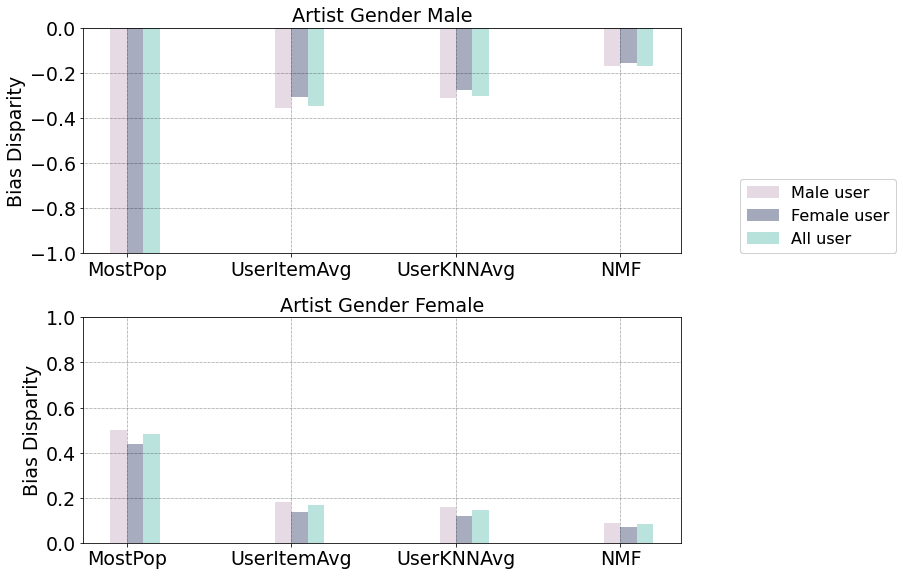

In [64]:
# create plot for bias disparity
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(10, 20))
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

colours_inputpr = ['r', 'g']
titles = ['Male', 'Female']
colours = ['#E0D3DE', '#9197AE', '#A9DDD6']
user_genders = ['Male user', 'Female user', 'All user']

for j in range(len(all_bd)):
    for i in range(3):
        #print(i)
        plt.subplot(5, 1, j+1)
        #print(all_bd[j][i])
        rects1 = plt.bar(index + bar_width*i, all_bd[j][i], bar_width,
        alpha=opacity,
        color=colours[i],
        label=user_genders[i])
    
    #plt.xlabel('Algorithm')
    plt.ylabel('Bias Disparity', size ='19')
    title = 'Artist Gender ' + titles[j] 
    plt.title(title)
    plt.xticks(index + (0.5*bar_width), ('MostPop', 'UserItemAvg', 'UserKNNAvg', 'NMF'))
    
    plt.tick_params(axis='both', which='major', labelsize=19)
    
    if(j == 0):
        plt.ylim(-1,0)
        legend1 = plt.legend(loc=(1.1,0))
        plt.gca().add_artist(legend1)
    else: plt.ylim(0, 1)
    
    plt.grid(linestyle=':', linewidth='0.5', color='black')
    
plt.tight_layout()
#plt.savefig('bias-disparity.png')
plt.show()

### 4. Evaluation Against Testset

In [65]:
threshold = 70 # consider item as relevent if it has recieved a rating of >= 70 after log scaling

Recall@n
$$\text { Recall@N }=\frac{1}{|\mathcal{U}|} \sum_{u \in \mathcal{U}} \frac{\left|\mathcal{I}_{u}^{\mathcal{T}}+\cap \mathcal{P}_{u}\right|}{\left|\mathcal{I}_{u}^{\mathcal{T}}+\right|}$$

In [66]:
# recall@n 
def rn(topn, testset):
    U_rn = [] #r@n list for all users
    i = 0
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset

    for user_id, item_rec in topn.items():
        # collection of artist ids which are deemed 'relevent' in users listening history
        x = df_testfold[(df_testfold['user'] == user_id) & 
                        (df_testfold['playcount'] >= threshold)]['artist'].values.tolist()
        rec_test_unison = list(set(x) & set(item_rec))
        if len(x) == 0: rn = 0
        else: rn = len(rec_test_unison) / len(x)  
        U_rn.append(rn)  
    return np.mean(U_rn)

nDCG@N
$$D C G_{u}=\sum_{i=1}^{N} \frac{r_{u, i}}{\log _{2}(i+1)}$$

In [67]:
# nDCG@n
def nDCGn_mod(topn, testset):
    U_nDCGn = [] #ndcgn list for all users    
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset

    for user_id, item_rec in topn.items():
        # actual ratings of recommended items
        rec_items = df_testfold[(df_testfold.user == user_id) & 
                        (df_testfold.artist.isin(item_rec))]
        
        rec_playcounts = []
        for i in item_rec:
            p_c = df_testfold[(df_testfold.user == user_id) & (df_testfold.artist == i)].playcount.tolist()
            if p_c == []: p_c = 0
            else: p_c = p_c[0]
            rec_playcounts.append(p_c)
            
        # rating of all listened to items in the testset for user u
        testset_items = df_testfold[(df_testfold.user == user_id)]
        ideal_item_order = testset_items.sort_values(by=['playcount'], ascending=False).playcount.tolist()[:10]
        
        dcg_result = dcg(rec_playcounts)
        idcg_result = dcg(ideal_item_order)
        U_nDCGn.append(dcg_result/idcg_result) 
    return np.mean(U_nDCGn) 

def dcg(p_c):
    n = 1
    dcg = 0  
    
    # for all ordered playcounts
    for p in p_c:
        dcg += p / np.log2(n+1)
        n+=1
    return dcg

Precision@n
$$\text { Precision@N }=\frac{1}{N|u|} \sum_{u \in \mathcal{U}}\left|\mathcal{I}_{u}^{\mathcal{T}+} \cap \mathcal{P}_{u}\right|$$

In [68]:
# p@n
def pn(topn, testset, n):
    U_pn = [] #p@n list for all users
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    
    for user_id, item_rec in topn.items():
        # collection of artist ids which are deemed 'relevent' in users listening history
        x = df_testfold[(df_testfold['user'] == user_id) & 
                        (df_testfold['playcount'] >= threshold)]['artist'].values.tolist()
        
        rec_test_unison = list(set(x) & set(item_rec))
        pn = len(rec_test_unison) / n
        U_pn.append(pn)  
    return np.mean(U_pn)

Coverage@n
$$\text { Coverage@N }=\frac{\left|\cup_{u \in \mathcal{U}} \mathcal{P}_{u}\right|}{|\mathcal{I}|}$$

In [69]:
# coverage@n
def cn(topn, testset):
    topn_unique_artists = set([j for sub in topn.values() for j in sub]) #all unique artist recommended in top n
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    testset_unique_artists = df_testfold['artist'].unique()    
    return len(topn_unique_artists)/len(testset_unique_artists)

Gini@N
$$\operatorname{Gini} @ \mathrm{N}=\frac{1}{|\mathcal{I}|}\left(|\mathcal{I}|+1-2 \frac{\sum_{j=1}^{|\mathcal{I}|}(|\mathcal{I}|+1-j) f[j]}{\sum_{j=1}^{|\mathcal{I}|} f[j]}\right)$$

In [70]:
def gn(topn, testset):
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    I = df_testfold['artist'].unique() #for consistency with the formal notation
    topn_artists = [j for sub in topn.values() for j in sub]
    f = list(pd.Series(topn_artists).value_counts())
    zero_pad = np.zeros(len(I) - len(f)) #zero pad represents the freq count for items which were not recommended
    f.extend(zero_pad)
    f.reverse()

    numer = sum(f) #numerator   
    denom = 0 #denomonator
    for j in np.arange(len(I)):
        denom += (len(I) - j)*f[j] #note the +1 term is implied as we start at index 0, not 1    
    return (len(I)+1-(2*denom/numer))/ len(I)

Spread
$$\text {spread}=-\sum_{i \in I} P(i) \log P(i)$$

In [71]:
def spread(topn, testset):
    testset.columns = ['user', 'artist', 'playcount']
    df_testfold = testset
    I = df_testfold['artist'].unique() #for consistency with the formal notation
    topn_artists = [j for sub in topn.values() for j in sub]
    f = list(pd.Series(topn_artists).value_counts())
    count_I = sum(f) 
    p_i = [count_i / count_I for count_i in f]
    s_i = p_i * np.log2(p_i) #spread for each item
    s = - sum(s_i) #total spread
    return s

### Novelty Meausres

Expected Popularity Complement
$$E P C=\frac{\sum_{i \in \mathbf{R}}(1-p o p(i))}{|\mathbf{R}|}$$

In [72]:
def epc(topn):
    topn_artists = [j for sub in topn.values() for j in sub]
    f = list(pd.Series(topn_artists).value_counts())
    max_pop = f[0]
    normalised_pop = [1-(i/max_pop) for i in f]
    sum_pop = sum(normalised_pop)
    epc = sum_pop / len(f)
    return epc

%Long Tail:
$$\% \text {Long-tail}=\frac{\sum_{i \in \text {Long-tail}} \operatorname{rec}(i)}{\text {total}}$$

In [73]:
def perc_lt(topn):
    topn_artists = [j for sub in topn.values() for j in sub]
    total = len(topn_artists) #number of recommendations made
    f = pd.Series(topn_artists).value_counts().to_frame() #frequency of artist recommendations
    
    # filter to only include values which are in the long tail
    f['artist'] = f.index
    f_filt = f[f['artist'].isin(lt_artists)]
    rec_lt = f_filt[0].sum()
    return rec_lt/total

### Evaluation

In [74]:
## Accuracy metric computation:
# (1) p@n
# (2) nDCG@N
## Beyond accuracy metric computations:
# - Aggregate Diversity
# (1) coverage@n
# (2) spread
# - Novelty
# (1) longtail perc.

eval_metrics = ['p@n', 'nDCG@N', 'c@n', 'spread', 'longtail_perc']
evaluation_dict = {a:{e:[] for e in eval_metrics} for a in algo_names}
evaluation_dict_m = {a:{e:[] for e in eval_metrics} for a in algo_names}
evaluation_dict_f = {a:{e:[] for e in eval_metrics} for a in algo_names}

n = 5 #for each rec alg topn results = 10
algo_dicts = sample_algo_results_dfs
#algo_test_sets = fold_testsets

for algo_name, rec_alg in algo_dicts.items():
        
    # accuracy results for each fold
    kfold_pn = []
    kfold_pn_m = []
    kfold_pn_f = []

    kfold_ndcgn = []
    kfold_ndcgn_m = []
    kfold_ndcgn_f = []
    
    # beyond accuracy - aggregate diveristy for each fold
    kfold_cn = []
    kfold_cn_m = []
    kfold_cn_f = []

    kfold_spread = []
    kfold_spread_m = []
    kfold_spread_f = []
    
    # beyond accuracy - novelity measures for each fold
    kfold_longtail = []
    kfold_longtail_m = []
    kfold_longtail_f = []
    
    # for each fold of kfold val...
    for k in range(num_folds):
        print('k =', k)
            
        topn_recs = rec_alg[k]
        topn_recs = topn_recs.groupby('user_id')['rec_artist'].apply(list).to_dict() #key = u_id, items = recommendations
        
        user_ids = topn_recs.keys()
  
        user_m_ids = list(set(m_user_ids) & set(user_ids))
        user_f_ids = list(set(f_user_ids) & set(user_ids))
        
        topn_recs_m = {key:value for (key,value) in topn_recs.items() if key in user_m_ids}
        topn_recs_f = {key:value for (key,value) in topn_recs.items() if key in user_f_ids}
        
        testset = fold_testsets[k]
        trainset = fold_trainsets[k]
        
        #testset = top_n_testset
        #trainset = sample_df_events
        

        patn = pn(topn_recs,testset,n)          #compute p@n for this fold
        patn_m = pn(topn_recs_m,testset,n)  
        patn_f = pn(topn_recs_f,testset,n)  
        
        ndcgn = nDCGn_mod(topn_recs,testset)    #compute nDCGn for this fold
        ndcgn_m = nDCGn_mod(topn_recs_m,testset)
        ndcgn_f = nDCGn_mod(topn_recs_f,testset)
        
        catn = cn(topn_recs,testset)            #compute c@n for this fold
        catn_m = cn(topn_recs_m,testset)    
        catn_f = cn(topn_recs_f,testset)            
                
        spreadn = spread(topn_recs,testset)     #compute spread for this fold
        spreadn_m = spread(topn_recs_m,testset)
        spreadn_f = spread(topn_recs_f,testset)        
        
        longt_perc = perc_lt(topn_recs)         #compute long tail percentage for this fold
        longt_perc_m = perc_lt(topn_recs_m)   
        longt_perc_f = perc_lt(topn_recs_f)     
         
        kfold_pn.append(patn)
        kfold_pn_m.append(patn_m)
        kfold_pn_f.append(patn_f)
    
        kfold_ndcgn.append(ndcgn)
        kfold_ndcgn_m.append(ndcgn_m)
        kfold_ndcgn_f.append(ndcgn_f)
        
        kfold_cn.append(catn)
        kfold_cn_m.append(catn_m)
        kfold_cn_f.append(catn_f)
                
        kfold_spread.append(spreadn)
        kfold_spread_m.append(spreadn_m)
        kfold_spread_f.append(spreadn_f)
                
        kfold_longtail.append(longt_perc)
        kfold_longtail_m.append(longt_perc_m)
        kfold_longtail_f.append(longt_perc_f)
        
    # accuracy computations, average over each fold
    avg_pn = np.mean(kfold_pn)
    avg_pn_m = np.mean(kfold_pn_m)
    avg_pn_f = np.mean(kfold_pn_f)
    
    std_pn = np.std(kfold_pn)
    std_pn_m = np.std(kfold_pn_m)
    std_pn_f = np.std(kfold_pn_f)
                
    avg_ndcgn = np.mean(kfold_ndcgn)
    avg_ndcgn_m = np.mean(kfold_ndcgn_m)
    avg_ndcgn_f = np.mean(kfold_ndcgn_f)
    
    std_ndcgn = np.std(kfold_ndcgn)
    std_ndcgn_m = np.std(kfold_ndcgn_m)
    std_ndcgn_f = np.std(kfold_ndcgn_f)
    
    # beyond accuracy computations -aggregate diversity
    avg_cn = np.mean(kfold_cn)
    avg_cn_m = np.mean(kfold_cn_m)
    avg_cn_f = np.mean(kfold_cn_f)
    
    std_cn = np.std(kfold_cn)
    std_cn_m = np.std(kfold_cn_m)
    std_cn_f = np.std(kfold_cn_f)
                
    avg_spread = np.mean(kfold_spread)
    avg_spread_m = np.mean(kfold_spread_m)
    avg_spread_f = np.mean(kfold_spread_f)
    
    std_spread = np.std(kfold_spread)
    std_spread_m = np.std(kfold_spread_m)
    std_spread_f = np.std(kfold_spread_f)
                
    avg_lt_perc = np.mean(kfold_longtail)
    avg_lt_perc_m = np.mean(kfold_longtail_m)
    avg_lt_perc_f = np.mean(kfold_longtail_f)
    
    std_lt_perc = np.std(kfold_longtail)
    std_lt_perc_m = np.std(kfold_longtail_m)
    std_lt_perc_f = np.std(kfold_longtail_f)
    
    evaluation_dict[algo_name]['p@n'] = (avg_pn, std_pn)
    evaluation_dict[algo_name]['nDCG@N'] = (avg_ndcgn, std_ndcgn)
    evaluation_dict[algo_name]['c@n'] = (avg_cn, std_cn)
    evaluation_dict[algo_name]['spread'] = (avg_spread, std_spread)
    evaluation_dict[algo_name]['longtail_perc'] = (avg_lt_perc, std_lt_perc)
    
    evaluation_dict_m[algo_name]['p@n'] = (avg_pn_m, std_pn_m)
    evaluation_dict_m[algo_name]['nDCG@N'] = (avg_ndcgn_m, std_ndcgn_m)
    evaluation_dict_m[algo_name]['c@n'] = (avg_cn_m, std_cn_m)
    evaluation_dict_m[algo_name]['spread'] = (avg_spread_m, std_spread_m)
    evaluation_dict_m[algo_name]['longtail_perc'] = (avg_lt_perc_m, std_lt_perc_m)
    
    evaluation_dict_f[algo_name]['p@n'] = (avg_pn_f, std_pn_f)
    evaluation_dict_f[algo_name]['nDCG@N'] = (avg_ndcgn_f, std_ndcgn_f)
    evaluation_dict_f[algo_name]['c@n'] = (avg_cn_f, std_cn_f)
    evaluation_dict_f[algo_name]['spread'] = (avg_spread_f, std_spread_f)
    evaluation_dict_f[algo_name]['longtail_perc'] = (avg_lt_perc_f, std_lt_perc_f)
    
    print('\n{} algo, avg p@n: {}'.format(algo_name, avg_pn)) 
    print('{} algo, avg p@n male: {}'.format(algo_name, avg_pn_m)) 
    print('{} algo, avg p@n: {}'.format(algo_name, avg_pn_f)) 
    
    print('{} algo, avg nDCG@n: {}'.format(algo_name,avg_ndcgn))
    print('{} algo, avg nDCG@n male: {}'.format(algo_name,avg_ndcgn_m)) 
    print('{} algo, avg nDCG@n female: {}'.format(algo_name,avg_ndcgn_f)) 

    print('{} algo, avg c@n: {}'.format(algo_name,avg_cn)) 
    print('{} algo, avg c@n male: {}'.format(algo_name,avg_cn_m))
    print('{} algo, avg c@n female: {}'.format(algo_name,avg_cn_f)) 
    
    print('{} algo, avg spread: {}'.format(algo_name,avg_spread)) 
    print('{} algo, avg spread male: {}'.format(algo_name,avg_spread_m)) 
    print('{} algo, avg spread female: {}'.format(algo_name,avg_spread_f)) 
    
    print('{} algo, avg longt: {}'.format(algo_name,avg_lt_perc)) 
    print('{} algo, avg longt male: {}'.format(algo_name,avg_lt_perc_m)) 
    print('{} algo, avg longt female: {}\n'.format(algo_name,avg_lt_perc_f)) 

k = 0
k = 1
k = 2

Random algo, avg p@n: 0.012794612794612796
Random algo, avg p@n male: 0.011872146118721463
Random algo, avg p@n: 0.015384615384615385
Random algo, avg nDCG@n: 0.00831379805597571
Random algo, avg nDCG@n male: 0.007729361808931652
Random algo, avg nDCG@n female: 0.00995471521113787
Random algo, avg c@n: 0.7184628366789109
Random algo, avg c@n male: 0.6055649305040836
Random algo, avg c@n female: 0.2845136274551087
Random algo, avg spread: 8.996077427849123
Random algo, avg spread male: 8.769013033343642
Random algo, avg spread female: 7.765278934806684
Random algo, avg longt: 0.4777777777777778
Random algo, avg longt male: 0.46986301369863015
Random algo, avg longt female: 0.5

k = 0
k = 1
k = 2

MostPopular algo, avg p@n: 0.03636363636363637
MostPopular algo, avg p@n male: 0.038356164383561646
MostPopular algo, avg p@n: 0.03076923076923077
MostPopular algo, avg nDCG@n: 0.03769435067511382
MostPopular algo, avg nDCG@n male: 0.0351792907787335
MostPopular algo, avg nDC

### Compute statistical relevence

In [75]:

for eval_m in eval_metrics:
    i = 1
    for algo in algo_names[1:]:
        print('Algo: {}, Eval: {}'.format(algo,eval_m))
        
        evaluation_dict[algo]
        avg_m1 = evaluation_dict[algo][eval_m][0]
        std_m1 = evaluation_dict[algo][eval_m][1]
        
        for algo2 in algo_names[1:]:
            avg_m2 = evaluation_dict[algo2][eval_m][0]
            std_m2 = evaluation_dict[algo2][eval_m][1]
            # tvalue
            t = test_hypothesis(avg_m1, avg_m2, std_m1, std_m2, 3, 3)
            print('- {} - {} t value: {}\n'.format(algo,algo2,t))
        i+=1   
    print('\n')

Algo: MostPopular, Eval: p@n
- MostPopular - MostPopular t value: 0.0

- MostPopular - UserItemAvg t value: -105.483720946008

- MostPopular - UserKNNAvg t value: -98.23172803446953

- MostPopular - NMF t value: -114.83395621505063

Algo: UserItemAvg, Eval: p@n
- UserItemAvg - MostPopular t value: 105.483720946008

- UserItemAvg - UserItemAvg t value: 0.0

- UserItemAvg - UserKNNAvg t value: -3.5081300922551173

- UserItemAvg - NMF t value: -17.159627915216564

Algo: UserKNNAvg, Eval: p@n
- UserKNNAvg - MostPopular t value: 98.23172803446953

- UserKNNAvg - UserItemAvg t value: 3.5081300922551173

- UserKNNAvg - UserKNNAvg t value: 0.0

- UserKNNAvg - NMF t value: -12.675864902262425

Algo: NMF, Eval: p@n
- NMF - MostPopular t value: 114.83395621505063

- NMF - UserItemAvg t value: 17.159627915216564

- NMF - UserKNNAvg t value: 12.675864902262425

- NMF - NMF t value: 0.0



Algo: MostPopular, Eval: nDCG@N
- MostPopular - MostPopular t value: 0.0

- MostPopular - UserItemAvg t value: 

/home/sishakes/Dougals-work/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
